**Multi-Step Stock Price Forecasting using RNN and LSTM**
A Deep Learning Based Time-Series Analysis on AZN.L Stock Data

In [79]:
pip install yfinance

**Imports**



In [80]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline

**Data download**

In [81]:
# Download stock data
azn_df = yf.download("AZN.L", start="2010-01-01", end="2020-01-01")

# Fix MultiIndex columns
azn_df.columns = azn_df.columns.get_level_values(0)

# Keep only Close price
azn_df = azn_df[['Close']]

azn_df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close
Date,
2010-01-04,2922.759766
2010-01-05,2889.468506
2010-01-06,2857.170166
2010-01-07,2892.449463
2010-01-08,2890.462158


**Visualization**

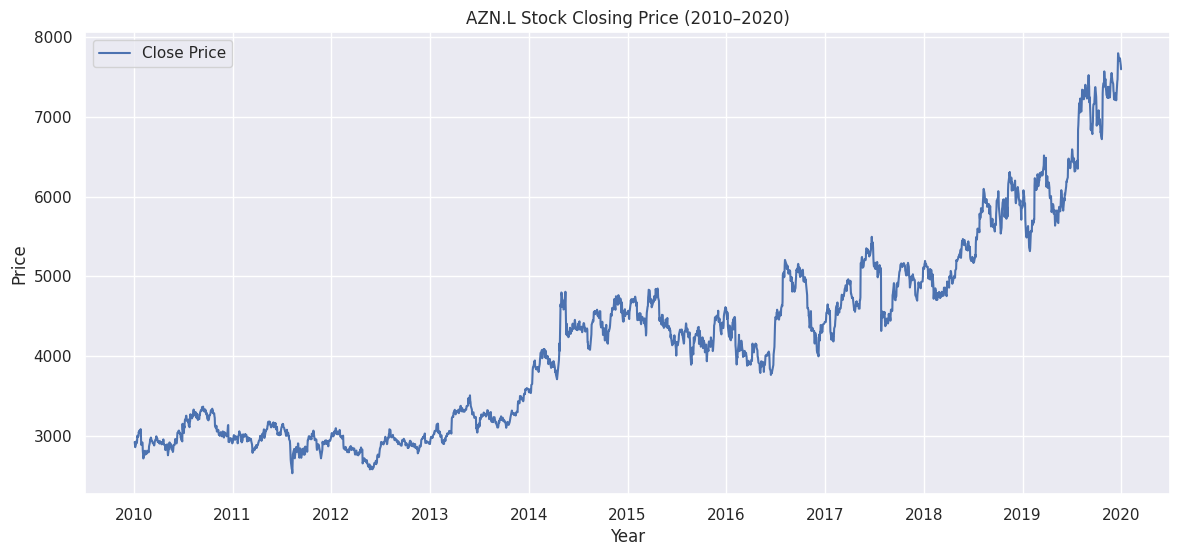

In [82]:
plt.figure(figsize=(14,6))
plt.plot(azn_df['Close'], label="Close Price")
plt.title("AZN.L Stock Closing Price (2010–2020)")
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

**Train-test split**

In [83]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def ts_train_test(data, time_steps=5, for_periods=2):
    """
    Prepare time-series training and testing datasets for deep learning models.

    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing stock prices with Date index and 'Close' column
    time_steps : int
        Number of past days used for prediction
    for_periods : int
        Number of future days to predict

    Returns:
    --------
    X_train, y_train : Training dataset
    X_test, y_test   : Testing dataset
    sc               : Fitted MinMaxScaler
    """

    # Split training and testing data
    train_data = data.loc[:'2016', ['Close']].values
    test_data  = data.loc['2017':, ['Close']].values

    # Scaling
    sc = MinMaxScaler(feature_range=(0, 1))
    train_scaled = sc.fit_transform(train_data)

    # Create training sequences
    X_train, y_train = [], []

    for i in range(time_steps, len(train_scaled) - for_periods + 1):
        X_train.append(train_scaled[i-time_steps:i, 0])
        y_train.append(train_scaled[i:i+for_periods, 0])

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Reshape for RNN/LSTM (samples, time_steps, features)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

    # Prepare test inputs
    total_data = pd.concat((data.loc[:'2016', 'Close'],
                            data.loc['2017':, 'Close']), axis=0).values

    inputs = total_data[len(total_data) - len(test_data) - time_steps:]
    inputs = inputs.reshape(-1, 1)
    inputs = sc.transform(inputs)

    X_test, y_test = [], []

    for i in range(time_steps, len(inputs) - for_periods + 1):
        X_test.append(inputs[i-time_steps:i, 0])
        y_test.append(inputs[i:i+for_periods, 0])

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    return X_train, y_train, X_test, y_test, sc

In [84]:
# Prepare data
X_train, y_train, X_test, y_test, sc = ts_train_test(azn_df, time_steps=5, for_periods=2)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)

X_train shape: (1762, 5, 1)
y_train shape: (1762, 2)
X_test shape : (757, 5, 1)
y_test shape : (757, 2)


In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout

# Build RNN
rnn_model = Sequential()

rnn_model.add(SimpleRNN(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
rnn_model.add(Dropout(0.2))

rnn_model.add(SimpleRNN(50))
rnn_model.add(Dropout(0.2))

rnn_model.add(Dense(25))
rnn_model.add(Dense(2))

rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train
history_rnn = rnn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1
)

# Predict
rnn_predictions = rnn_model.predict(X_test)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.1222 - val_loss: 0.0215
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0183 - val_loss: 0.0031
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 - val_loss: 0.0031
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 - val_loss: 0.0029
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0058 - val_loss: 0.0025
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058 - val_loss: 0.0025
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - val_

In [86]:
from tensorflow.keras.layers import LSTM

# Build LSTM
lstm_model = Sequential()

lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(25))
lstm_model.add(Dense(2))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1
)

# Predict
lstm_predictions = lstm_model.predict(X_test)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.0943 - val_loss: 0.0029
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - v

**Model Evaluation**

In [88]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(model_name, predictions, y_test, scaler):

    # Inverse transform
    predictions_inv = scaler.inverse_transform(predictions)
    y_test_inv = scaler.inverse_transform(y_test)

    # Flatten for overall metrics
    y_true = y_test_inv.flatten()
    y_pred = predictions_inv.flatten()

    # Metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    print(f"\nModel Evaluation: {model_name}")
    print("----------------------------------")
    print("MAE  :", mae)
    print("RMSE :", rmse)
    print("MAPE :", mape, "%")
    print("R2   :", r2)

    # Day-wise RMSE
    day1_rmse = np.sqrt(mean_squared_error(y_test_inv[:, 0], predictions_inv[:, 0]))
    day2_rmse = np.sqrt(mean_squared_error(y_test_inv[:, 1], predictions_inv[:, 1]))

    print("\nDay 1 RMSE:", day1_rmse)
    print("Day 2 RMSE:", day2_rmse)

In [89]:
evaluate_model("RNN", rnn_predictions, y_test, sc)
evaluate_model("LSTM", lstm_predictions, y_test, sc)


Model Evaluation: RNN
----------------------------------
MAE  : 321.7285375557299
RMSE : 436.7735241857663
MAPE : 5.1518492195062375 %
R2   : 0.7460748450013586

Day 1 RMSE: 455.16461269694855
Day 2 RMSE: 417.5732249650893

Model Evaluation: LSTM
----------------------------------
MAE  : 161.0926060544295
RMSE : 226.77717726682604
MAPE : 2.617340987565427 %
R2   : 0.9315471070720669

Day 1 RMSE: 227.41181240367808
Day 2 RMSE: 226.14076111460577


**Predictions**

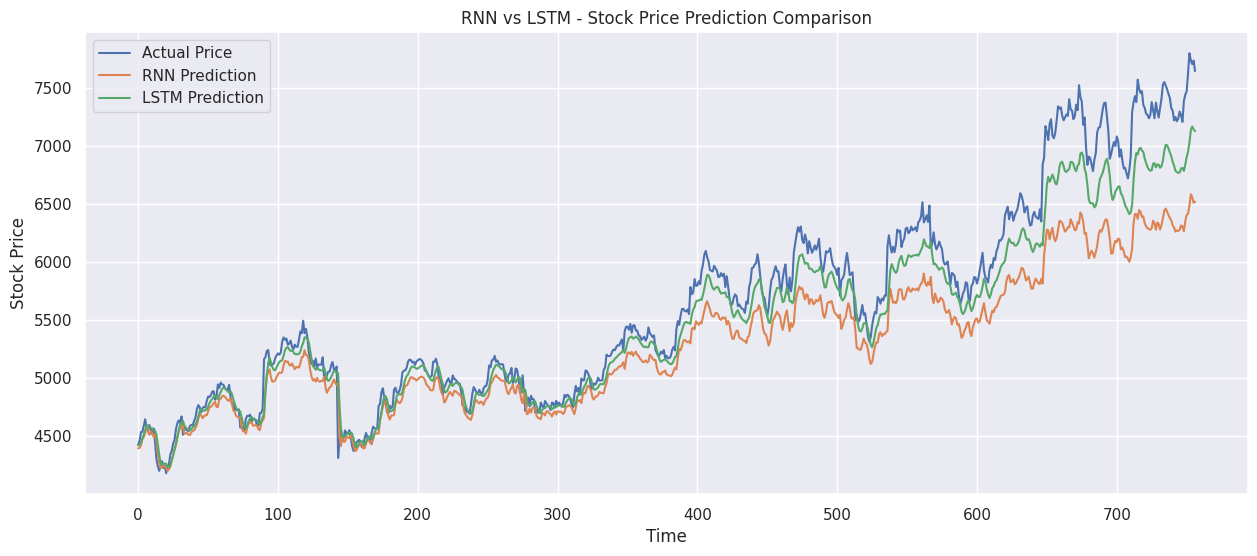

In [91]:
# Inverse transform predictions
rnn_pred_actual = sc.inverse_transform(rnn_predictions)
lstm_pred_actual = sc.inverse_transform(lstm_predictions)
y_test_actual = sc.inverse_transform(y_test)

# Use only Day 1 prediction for comparison
rnn_day1 = rnn_pred_actual[:, 0]
lstm_day1 = lstm_pred_actual[:, 0]
actual_day1 = y_test_actual[:, 0]

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    "Actual": actual_day1,
    "RNN Prediction": rnn_day1,
    "LSTM Prediction": lstm_day1
})

# Plot
plt.figure(figsize=(15,6))
plt.plot(comparison_df["Actual"], label="Actual Price")
plt.plot(comparison_df["RNN Prediction"], label="RNN Prediction")
plt.plot(comparison_df["LSTM Prediction"], label="LSTM Prediction")

plt.title("RNN vs LSTM - Stock Price Prediction Comparison")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

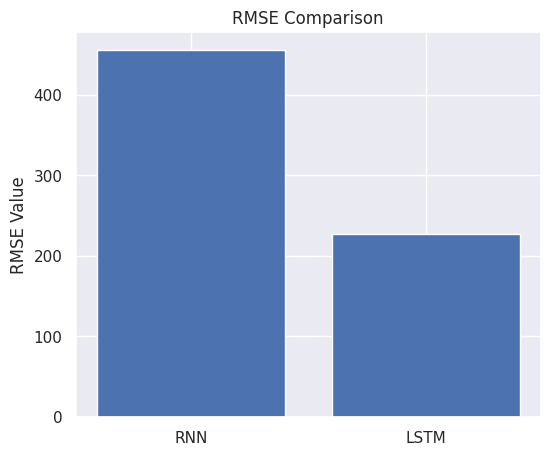

RNN RMSE: 455.16461269694855
LSTM RMSE: 227.41181240367808


In [92]:
from sklearn.metrics import mean_squared_error

rnn_rmse = np.sqrt(mean_squared_error(actual_day1, rnn_day1))
lstm_rmse = np.sqrt(mean_squared_error(actual_day1, lstm_day1))

plt.figure(figsize=(6,5))
plt.bar(["RNN", "LSTM"], [rnn_rmse, lstm_rmse])
plt.title("RMSE Comparison")
plt.ylabel("RMSE Value")
plt.show()

print("RNN RMSE:", rnn_rmse)
print("LSTM RMSE:", lstm_rmse)